In [1]:
import urllib
from urllib.parse import urlparse
import urllib.request
from urllib.error import HTTPError
import requests
from io import StringIO  
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import nltk
import string
from nltk.corpus import stopwords
wn = nltk.WordNetLemmatizer()
from nltk.tokenize import word_tokenize,sent_tokenize
nltk.download('wordnet')
nltk.download("stopwords")
nltk.download('punkt')
string.punctuation

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

##Connecting with the SEMRush API & Function to plot

In [2]:
### Load API Key and root url for API call ###
api_key = '16b2f177f5b32320b3b66fd4edcaf2da'
service_url = 'https://api.semrush.com'
domain = 'https://suave.com'
call_type = 'domain_organic'
### Function used to monitor credit use for SEMrush API ###
def semrush_call(call_type, phrase):
  params = {
      "?type": call_type,
      'key': api_key,
      'domain': domain,
      'database': 'us', # change for different market
      'display_limit': '100',
      "export_columns":"Ph,Po,Pp,Pd,Nq,Cp,Ur,Tr,Tc,Co,Nr,Td"
      }
  data = urllib.parse.urlencode(params, doseq=True)
  main_call = urllib.parse.urljoin(service_url, data)
  main_call = main_call.replace(r'%3F', r'?')
  return main_call
### Function used to parse data from semrush_call###  
def parse_response(call_data):
  results = []
  data = call_data.decode('unicode_escape')
  lines = data.split('\r\n')
  lines = list(filter(bool, lines))
  columns = lines[0].split(';')
  for line in lines[1:]:
    result = {}
    for i, datum in enumerate(line.split(';')):
      result[columns[i]] = datum.strip('"\n\r\t')
      results.append(result)
  return results

##Preprocessing the Dataset

In [137]:
#SETTING THE DATAFRAME FROM THE SEMRUSH CVS EXTRACTION
gk = pd.read_csv("suave vs tresemme.csv", sep=',', decimal=',')
#gk=gk.sort_values(by='Position',ascending=True)##Changing name columns
ppal_brand = input("Enter your principal brand name: ")
sec_brand = input("Enter your competitor brand name: ")

Enter your principal brand name: suave
Enter your competitor brand name: tresemme


In [138]:
gk.rename(columns={ gk.columns[1]: ppal_brand }, inplace = True)
gk.rename(columns={ gk.columns[2]: sec_brand }, inplace = True)
gk.rename(columns={ gk.columns[8]: ppal_brand + ' (urls)' }, inplace = True)
gk.rename(columns={ gk.columns[9]: sec_brand + ' (urls)' }, inplace = True)
gk=gk.drop(columns=['CPC','Keyword Difficulty','Competition','Results'])
print(gk.columns)

Index(['Keyword', 'suave', 'tresemme', 'Search Volume', 'suave (urls)',
       'tresemme (urls)'],
      dtype='object')


In [139]:
gk

,Keyword,suave,tresemme,Search Volume,suave (urls),tresemme (urls)
0,hair brands,28,92,1000,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html
1,hair products website,67,55,140,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html
2,hair hygiene,90,97,110,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html
3,unilever near me,26,41,110,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html
4,you hair products,85,34,110,https://www.suave.com/us/en/hair.html,https://www.tresemme.com/us/en/home.html
5,caring products uk ltd,26,69,90,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html
6,o care hair,87,84,90,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html
7,tr natural hair pomade,61,24,90,https://www.suave.com/us/en/natural-hair-campa...,https://www.tresemme.com/us/en/home.html
8,unilever hair shampoos,30,68,90,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html
9,buy professional shampoo online,95,98,70,https://www.suave.com/us/en/hair/professionals...,https://www.tresemme.com/us/en/home.html


##NLP Preprocessing

*   Remove special characters
*   Lowercase all texts
*   Convert number words to numeric form
*   Remove numbers
*   Remove stopwords
*   Lemmatization



In [140]:
stop_words = nltk.corpus.stopwords.words('english')
#stop_words.extend(['suave','best','free','like','great','better','how','no','product','products','where','how','what']) 
#print(stop_words)
def clean_text(txt):
  txt_nopunct= "".join([c for c in txt if c not in string.punctuation])
  tokens = re.split('\W+',txt)
  txt_clean= "".join([word for word in txt_nopunct if word not in stop_words])
  #lemma= "".join([wn.lemmatize(txt_clean) for txt_clean in txt])
  return txt_clean

In [141]:
gk['clean text'] = gk['Keyword'].apply(lambda x: clean_text(x.lower()))
gk

,Keyword,suave,tresemme,Search Volume,suave (urls),tresemme (urls),clean text
0,hair brands,28,92,1000,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html,hr brn
1,hair products website,67,55,140,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html,hr pruc webe
2,hair hygiene,90,97,110,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html,hr hgene
3,unilever near me,26,41,110,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html,unlever ner e
4,you hair products,85,34,110,https://www.suave.com/us/en/hair.html,https://www.tresemme.com/us/en/home.html,u hr pruc
5,caring products uk ltd,26,69,90,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html,crng pruc uk l
6,o care hair,87,84,90,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html,cre hr
7,tr natural hair pomade,61,24,90,https://www.suave.com/us/en/natural-hair-campa...,https://www.tresemme.com/us/en/home.html,r nurl hr pe
8,unilever hair shampoos,30,68,90,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html,unlever hr hp
9,buy professional shampoo online,95,98,70,https://www.suave.com/us/en/hair/professionals...,https://www.tresemme.com/us/en/home.html,bu prfenl hp nlne


In [142]:
stop__words = nltk.corpus.stopwords.words('english')
stop__words.extend(['suave','to','and','best','like','great','better','which','has','have','in','to','how','no','in','for','is','what','does','product','products','hair', 'good','free']) 
print(len(stop__words))

203


## Word Vectorizer

In [143]:
Tfidf_vect=TfidfVectorizer(stop_words=stop__words)
X_ftd=Tfidf_vect.fit_transform(gk['Keyword'])
temp=X_ftd.todense()

   index     terms     count
0      4      care  5.820627
1     49  unilever  3.305036
2     34   shampoo  2.530630
3      2    brands  2.297083
4     39     style  2.000000
{0: 'care', 1: 'unilever', 2: 'shampoo', 3: 'brands', 4: 'style'}


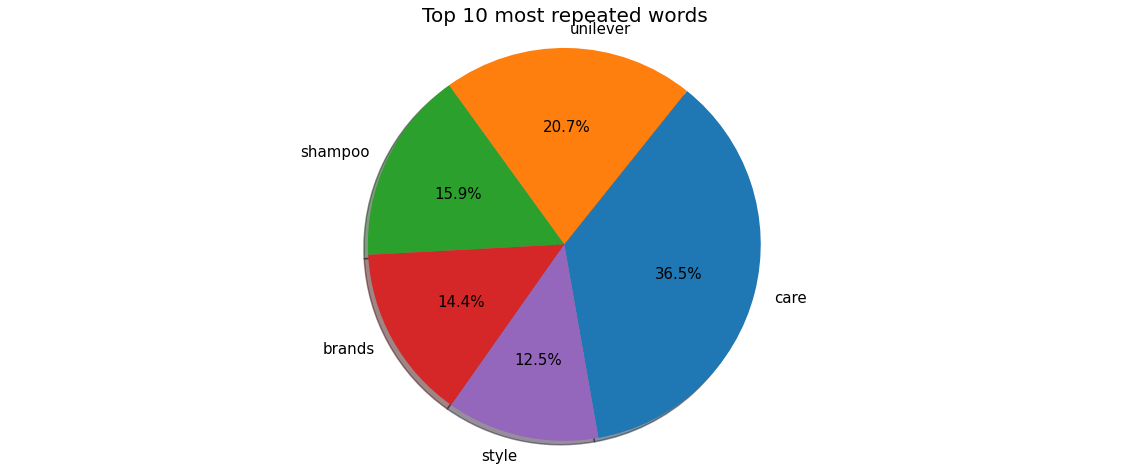

In [144]:
df_=pd.DataFrame({'terms':Tfidf_vect.get_feature_names(),'count':[array.sum() for array in X_ftd.toarray().T]}).\
    sort_values('count',ascending=False)[0:5]
df_=df_.reset_index()
print(df_)
dictionary=df_['terms'].to_dict()
print(dictionary)
plt.subplots(figsize=(20,8))
plt.pie(df_['count'],\
        labels=df_.terms,\
        autopct='%1.1f%%', shadow=True, startangle=-80, textprops={'fontsize': 15})
plt.title('Top 10 most repeated words',fontsize= 20)
plt.axis('equal')
plt.show()

##LDA Generative Model

In [145]:
vect=CountVectorizer(stop_words=stop__words)
X_ftd=vect.fit_transform(gk['Keyword'])
temp=X_ftd.todense()

In [187]:
a={}
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        #b.append(topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        a[topic_idx]=(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    #dic=pd.DataFrame({'category':a})
    return a
# Tweak the two parameters below
number_topics = 10
number_words = 1
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(X_ftd)
# Print the topics found by the LDA model
print("Topics found via LDA:")
dic=print_topics(lda, vect, number_words)
#dic=dic.values.tolist()
dic

Topics found via LDA:

Topic #0:
style

Topic #1:
care

Topic #2:
shampoo

Topic #3:
care

Topic #4:
shampoo

Topic #5:
brands

Topic #6:
brands

Topic #7:
range

Topic #8:
german

Topic #9:
unilever


{0: 'style',
 1: 'care',
 2: 'shampoo',
 3: 'care',
 4: 'shampoo',
 5: 'brands',
 6: 'brands',
 7: 'range',
 8: 'german',
 9: 'unilever'}

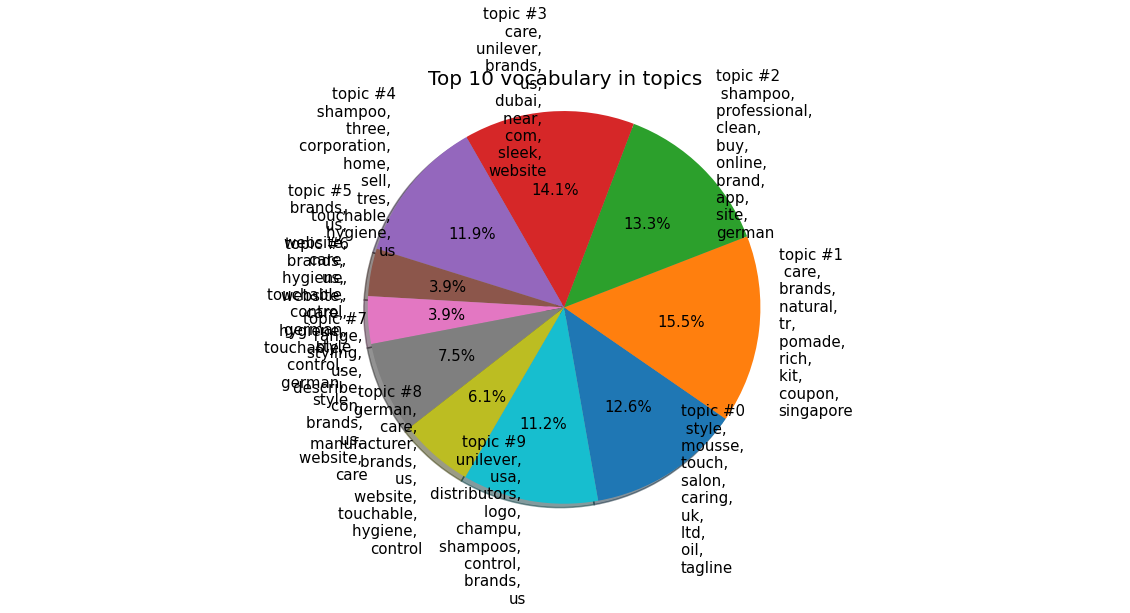

In [188]:
topic=[]
for k in range(0,len([x.sum() for x in lda.components_])):
    words=', \n'.join([vect.get_feature_names()[i] for i in lda.components_.argsort()[k][:-10:-1]])
    topic.append(str('topic #'+str(k)+'\n '+words))

plt.subplots(figsize=(20,8))
plt.pie([x.sum() for x in lda.components_],\
        labels=topic,\
        autopct='%1.1f%%', shadow=True, startangle=-80, textprops={'fontsize': 15})
plt.title('Top 10 vocabulary in topics',fontsize= 20)
plt.axis('equal')
plt.show()

### LSA Model

In [189]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
documents = gk['Keyword']
  
# raw documents to tf-idf matrix: 
vectorizer = TfidfVectorizer(stop_words='english', 
                             use_idf=True, 
                             smooth_idf=True)
# SVD to reduce dimensionality: 
svd_model = TruncatedSVD(n_components=5,         ## num dimensions
                         algorithm='randomized',
                         n_iter=10)
# pipeline of tf-idf + SVD, fit to and applied to documents:
svd_transformer = Pipeline([('tfidf', vectorizer), 
                            ('svd', svd_model)])
svd_matrix = svd_transformer.fit_transform(documents)
# svd_matrix can later be used to compare documents, compare words, or compare queries with documents

In [190]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 0: 
hair
 
products
 
care
 
style
 
german
 
brands
 
unilever
 
Topic 1: 
unilever
 
brands
 
usa
 
products
 
near
 
dubai
 
shampoos
 
Topic 2: 
care
 
unilever
 
usa
 
distributors
 
coupon
 
near
 
range
 
Topic 3: 
shampoo
 
german
 
brands
 
corporation
 
tres
 
site
 
brand
 
Topic 4: 
brands
 
hair
 
german
 
hygiene
 
oil
 
tagline
 
kit
 


##Assigning topics to dataframe keywords

In [191]:
# Create Document — Topic Matrix
lda_output = lda.transform(X_ftd)
# column names
topicnames = ['Topic' + str(i) for i in range(lda.n_components)]
# index names
docnames = ['Keyword' + str(i) for i in range(len(gk))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Keyword0,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05,0.05,0.05,4
Keyword1,0.05,0.05,0.05,0.55,0.05,0.05,0.05,0.05,0.05,0.05,3
Keyword2,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05,0.05,0.05,4
Keyword3,0.03,0.03,0.03,0.70,0.03,0.03,0.03,0.03,0.03,0.03,3
Keyword4,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0
Keyword5,0.77,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0
Keyword6,0.05,0.55,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,1
Keyword7,0.03,0.77,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,1
Keyword8,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.70,9
Keyword9,0.02,0.02,0.82,0.02,0.02,0.02,0.02,0.02,0.02,0.02,2


In [192]:
gk['Category']=df_document_topic['dominant_topic'].values
gk['Category']=gk['Category'].map(dic)
gk

,Keyword,suave,tresemme,Search Volume,suave (urls),tresemme (urls),clean text,Category,ach SoV,suave SOV,tresemme SOV
0,hair brands,28,92,1000,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html,hr brn,shampoo,10.0,0.0,0.000
1,hair products website,67,55,140,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html,hr pruc webe,care,1.4,0.0,0.000
2,hair hygiene,90,97,110,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html,hr hgene,shampoo,1.1,0.0,0.000
3,unilever near me,26,41,110,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html,unlever ner e,care,1.1,0.0,0.000
4,you hair products,85,34,110,https://www.suave.com/us/en/hair.html,https://www.tresemme.com/us/en/home.html,u hr pruc,style,1.1,0.0,0.000
5,caring products uk ltd,26,69,90,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html,crng pruc uk l,style,0.9,0.0,0.000
6,o care hair,87,84,90,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html,cre hr,care,0.9,0.0,0.000
7,tr natural hair pomade,61,24,90,https://www.suave.com/us/en/natural-hair-campa...,https://www.tresemme.com/us/en/home.html,r nurl hr pe,care,0.9,0.0,0.000
8,unilever hair shampoos,30,68,90,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html,unlever hr hp,unilever,0.9,0.0,0.000
9,buy professional shampoo online,95,98,70,https://www.suave.com/us/en/hair/professionals...,https://www.tresemme.com/us/en/home.html,bu prfenl hp nlne,shampoo,0.7,0.0,0.000


In [193]:
ctr = {1:0.28, 2:.17,3:.1,4:.07,5:.05,6:.03,7:.02,8:.02,9:.01,10:.01}

In [194]:
gk['ach SoV']=gk['Search Volume']*0.01

gk[ppal_brand + ' SOV'] = (gk[ppal_brand].map(ctr))*gk['ach SoV']
gk[sec_brand + ' SOV'] = (gk[sec_brand].map(ctr))*gk['ach SoV']
gk=gk.fillna(0)
gk=gk.sort_values(by=[ppal_brand + ' SOV'], ascending=False)
gk.head(20)

,Keyword,suave,tresemme,Search Volume,suave (urls),tresemme (urls),clean text,Category,ach SoV,suave SOV,tresemme SOV
0,hair brands,28,92,1000,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html,hr brn,shampoo,10.0,0.0,0.000
21,shampoo tres,20,2,50,https://www.suave.com/us/en/products/3-in-1-ha...,https://www.tresemme.com/us/en/home.html,hp re,shampoo,0.5,0.0,0.085
23,unilever brands us,20,67,50,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html,unlever brn u,care,0.5,0.0,0.000
24,unilever distributors usa,32,71,50,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html,unlever rbur u,unilever,0.5,0.0,0.000
25,unilever products usa,16,37,50,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html,unlever pruc u,unilever,0.5,0.0,0.000
26,champu logo,56,97,40,https://www.suave.com/us/en/hair/shampoo.html,https://www.tresemme.com/us/en/home.html,chpu lg,unilever,0.4,0.0,0.000
27,describe the use for the range of styling prod...,25,54,40,https://www.suave.com/us/en/hair/styling-produ...,https://www.tresemme.com/us/en/home.html,ecrbe he ue fr he rnge f lng pruc,range,0.4,0.0,0.000
28,hair products supplier singapore,32,23,40,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html,hr pruc uppler ngpre,care,0.4,0.0,0.000
29,tagline for hair oil,50,68,40,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html,glne fr hr l,style,0.4,0.0,0.000
30,care me products,57,90,30,https://www.suave.com/us/en,https://www.tresemme.com/us/en/home.html,cre e pruc,care,0.3,0.0,0.000


In [195]:
#TOTAL RANKINGS PER CATEGORY
categories = gk.groupby(by=['Category']).sum()
te=gk.groupby(by=['Category']).count()
categories['KWCount']=te['Keyword']
categories=categories.sort_values(by=['Search Volume'], ascending=False)
categories.reset_index(inplace=True)
categories = categories.round(1)
#categories = categories.loc[categories[ppal_brand + ' SOV'] * categories[sec_brand + ' SOV'] != 0]
categories

,Category,suave,tresemme,Search Volume,ach SoV,suave SOV,tresemme SOV,KWCount
0,shampoo,744,866,1570,15.7,0.0,0.1,12
1,care,675,955,930,9.3,0.0,0.0,15
2,style,282,363,340,3.4,0.0,0.0,6
3,unilever,161,349,280,2.8,0.0,0.0,5
4,range,124,94,110,1.1,0.0,0.0,2
5,german,47,75,50,0.5,0.0,0.0,1


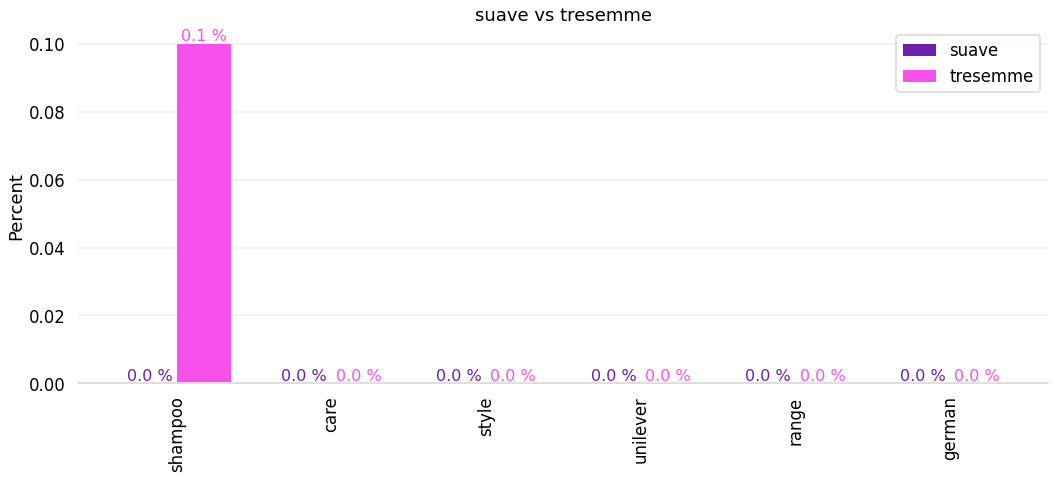

In [196]:
sns.set_context('talk')

labels = categories['Category']
ppal = categories[ppal_brand + ' SOV']
second = categories[sec_brand + ' SOV']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15,7))
b1 = ax.bar(x - width/2, ppal, width, label=ppal_brand, color = '#6b1ea9')
b2 = ax.bar(x + width/2, second, width, label=sec_brand, color = '#f652eb')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent')
ax.set_title(ppal_brand + ' vs ' + sec_brand)
#ax.set_title('Dove vs Function of beauty')

ax.set_xticks(x)
ax.set_xticklabels(labels)
# Add legend.
ax.legend()

# Axis styling.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
plt.xticks(rotation=90)

# You can just append this to the code above.

for bar in ax.patches:
  # The text annotation for each bar should be its height.
  bar_value = bar.get_height()
  # Format the text with commas to separate thousands. You can do
  # any type of formatting here though.
  text = f'{bar_value:,}' + ' %'
  # This will give the middle of each bar on the x-axis.
  text_x = bar.get_x() + bar.get_width() / 2
  # get_y() is where the bar starts so we add the height to it.
  text_y = bar.get_y() + bar_value
  # If we want the text to be the same color as the bar, we can
  # get the color like so:
  bar_color = bar.get_facecolor()
  # If you want a consistent color, you can just set it as a constant, e.g. #222222
  ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
          size=16)

fig.tight_layout()

plt.show()